In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

import io
import param
import panel as pn
import pandas as pd
import csv
import os
import random
import ipywidgets as ipw
import time
import plotly.express as px
import plotly.graph_objects as go
from scipy.optimize import curve_fit
from plotly.subplots import make_subplots
from pathlib import Path

import visualization

from tornado.ioloop import IOLoop
# from setup_stuff import read_csv, createObj
import FiberClass

# import plotly

pn.extension("plotly", sizing_mode = "stretch_width", loading_color = '#00aa41')

In [4]:
def parse_input(event = None):
    # .value param to extract variables properly
    value = file_input.value
    obj_name = input_1.value
    fiber_num = input_2.value
    animal_num = input_3.value
    exp_date = input_4.value
    exp_time = input_5.value
    
    if file_input:
        try:
            #Add to list
            input_params = []
            input_params.extend([obj_name, fiber_num, animal_num, exp_date, exp_time])
            string_io = io.StringIO(value.decode("utf8"))
            df = pd.read_csv(string_io) #Read into dataframe
        except FileNotFoundError:
            print("Could not find file: " + file_input)
            sys.exit(2)
        except PermissionError:
            print("Could not access file: " + file_input)
            sys.exit(3)
    
    if df.empty:
        print("Dataframe is empty")
        sys.exit(4)
    else:
        #Create new object
        new_obj = fiberObj(df, input_params[0], input_params[1], input_params[2], input_params[3], input_params[4])
        #Add to dict
        fiber_objs[input_params[0]] = new_obj
        existing_objs = fiber_objs
        obj_selecta.options = [*existing_objs] #Updates selector with new objects

        
# @pn.depends('obj_selecta.value', watch = True)
def plot_raw_trigger(event = None):
    # .value param to extract variables properly
    selected_objs = obj_selecta.value
    
    #For len of selected objs, create and plot raw signal graph
    for objs in selected_objs:
        temp = fiber_objs[objs]
        plot_pane = pn.pane.Plotly(height = 300, sizing_mode = "stretch_width") #Creates pane for plotting
        plot_pane.object = temp.raw_signal_trace() #Sets figure to plot variable
        # plot_pane.trigger('object')
        visuals.append(plot_pane) #Add figure to template


In [7]:
#Template and widget declarations

template = pn.template.MaterialTemplate(title='FiberPho GUI')
ACCENT_COLOR="#0072B5"

#List of objects
fiber_objs = {}

#Inputs
input_1 = pn.widgets.TextInput(name = 'Object Name', width = 90, placeholder = 'String')
input_2 = pn.widgets.IntInput(name = 'Fiber Number', width = 90, placeholder = 'Int')
input_3 = pn.widgets.IntInput(name = 'Animal Number', width = 90, placeholder = 'Int')
input_4 = pn.widgets.TextInput(name = 'Exp Date', width = 90, placeholder = 'Date')
input_5 = pn.widgets.TextInput(name = 'Exp Time', width = 90, placeholder = 'Time')
input_col = pn.Column(input_1, input_2, input_3, input_4, input_5)
#Inputs

#File input parameter
file_input = pn.widgets.FileInput(name = 'Upload FiberPho Data', accept = '.csv')


#Create fiber object button
upload_button = pn.widgets.Button(name = 'Create Object', button_type = 'primary', width = 500, sizing_mode = 'stretch_width', align = 'end')
upload_button.on_click(parse_input) #Button action
upload_box = pn.WidgetBox('# Input Params', file_input, input_col, upload_button)


obj_selecta = pn.widgets.MultiSelect(name = 'Fiber Objects', value = [], options = [], )


#Plot button and action
plot_raw_btn = pn.widgets.Button(name = 'Plot Raw Signal', button_type = 'primary', width = 500, sizing_mode = 'stretch_width', align = 'end')
plot_raw_btn.on_click(plot_raw_trigger)

plot_options = pn.Column(obj_selecta, plot_raw_btn)
plot_widgey = pn.WidgetBox('# Options', plot_options)

visuals = pn.Card(plot_widgey, title = 'Plot Raw Signal', background = 'WhiteSmoke', width = 600)

#Append widgets to gui template
template.sidebar.append(upload_box)
template.main.append(visuals)

# template.main.append(visuals)

In [6]:
# template = pn.template.MaterialTemplate(
#     site = "Donaldson Lab: Fiber Photometry", title = 'FiberPho GUI',
#     sidebar = ["**Upload new dataset** here", )
template.servable()

Traceback (most recent call last):
 File "/opt/homebrew/lib/python3.9/site-packages/pyviz_comms/__init__.py", line 325, in _handle_msg
 self._on_msg(msg)
 File "/opt/homebrew/lib/python3.9/site-packages/panel/viewable.py", line 272, in _on_msg
 patch.apply_to_document(doc, comm.id)
AttributeError: 'NoneType' object has no attribute 'id'

MaterialTemplate
    [js_area] HTML(None, height=0, margin=0, sizing_mode='fixed', width=0)
    [actions] MaterialTemplateActions()
    [busy_indicator] LoadingSpinner(height=20, width=20)
    [5205643904] WidgetBox(sizing_mode='stretch_width')
        [0] Markdown(str, sizing_mode='stretch_width')
        [1] FileInput(accept='.csv', name='Upload FiberPho Data', sizing_mode='stretch_width')
        [2] Column(sizing_mode='stretch_width')
            [0] TextInput(name='Object Name', placeholder='String', sizing_mode='stretch_width', width=90)
            [1] IntInput(name='Fiber Number', placeholder='Int', sizing_mode='stretch_width', width=90)
            [2] IntInput(name='Animal Number', placeholder='Int', sizing_mode='stretch_width', width=90)
            [3] TextInput(name='Exp Date', placeholder='Date', sizing_mode='stretch_width', width=90)
            [4] TextInput(name='Exp Time', placeholder='Time', sizing_mode='stretch_width', width=90)
        [3] Button(align='end', button_type='primary', name='Create Object', sizing_mode='stretch_width', width=500)
    [5205644624] Card(background='WhiteSmoke', button_css_classes=['mdc-button', ...], css_classes=['mdc-card'], margin=(10, 5), sizing_mode='stretch_width', title='Plot Raw Signal', title_css_classes=['mdc-card-title'], width=600)
        [0] WidgetBox(margin=(5, 10), sizing_mode='stretch_width')
            [0] Markdown(str, sizing_mode='stretch_width')
            [1] Column(sizing_mode='stretch_width')
                [0] MultiSelect(name='Fiber Objects', sizing_mode='stretch_width')
                [1] Button(align='end', button_type='primary', name='Plot Raw Signal', sizing_mode='stretch_width', width=500)

In [25]:
# print(fiber_objs)
# print(input_params[4])

NameError: name 'temp' is not defined

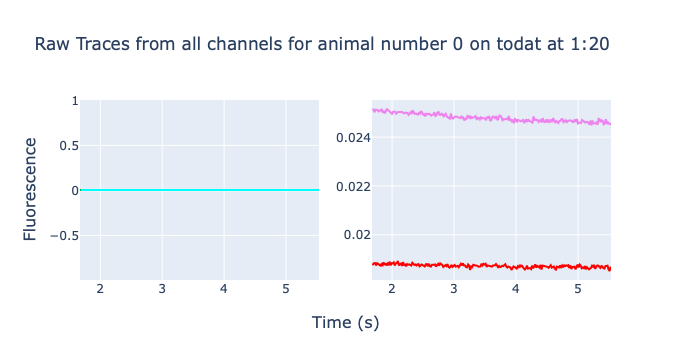

In [40]:
fiber_objs['test'].raw_signal_trace()
# print(obj_selecta.value[0])
##LEFT OFF HERE
# Successfully added obj to dict using gui
# Begin to build gui and display
# Figure out how to erase entries and allow for additional fiber obj creations

In [ ]:
# class TestButton(param.Parameterized):

#     action = param.Action(lambda x: x._print_something())
#     event = param.Event()

#     updating = param.Boolean()

#     @param.depends('event', watch = True)
#     def _print_something(self):
#         if self.updating:
#             return

#         self.updating = True
#         print(f'event: {self.event}, action: {self.action}')
#         time.sleep(1)
#         self.updating = False

# testbutton = TestButton()

# widgets=pn.Param(testbutton.param, parameters=["action", "event", "updating"])
# action_button = widgets[1]
# event_button = widgets[2]
# updating_checkbox = widgets[3]

# action_button.button_type="primary"
# event_button.button_type="primary"
# updating_checkbox.disabled=True

# @param.depends(testbutton.param.updating, watch=True)
# def toggle_loading(updating):
#     action_button.disabled = updating
#     event_button.disabled = updating

# dash = pn.Column(action_button, event_button, updating_checkbox)

# pn.panel(dash).servable()
